In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
pd.set_option('mode.chained_assignment',  None) # 경고를 끈다
pd.set_option('display.max_columns', None) # 모든 열 출력
pd.set_option('display.max_rows', None) # 모든 행 출력
plt.rcParams['axes.unicode_minus'] = False

In [2]:
taas = pd.read_csv('data/taas/taas_final.csv', encoding='cp949')

In [3]:
taas.head(1)

,사고번호,사고일시,요일,시군구,사고유형,법규위반,노면상태,기상상태,도로형태,가해운전자 차종,가해운전자 성별,가해운전자 연령,x,y,EPDO,연월,위치,이륜차,인구,기온,강수량,풍속,grid_id,단속카메라수,스쿨존수,음식점수,유흥주점수,단란주점수,교차로수,버스정류장수
0,2019010100100002,201901010000,화요일,서울특별시 구로구 고척동,차대차,안전운전불이행,건조,맑음,단일로 - 기타,이륜,남,청년,126.867286,37.499889,3,201901,서울특별시 구로구,15623,404049,-5.5,0.0,1.0,1980515.0,0.0,0.0,23.0,0.0,0.0,2,4.0


In [4]:
taas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61404 entries, 0 to 61403
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   사고번호      61404 non-null  int64  
 1   사고일시      61404 non-null  int64  
 2   요일        61404 non-null  object 
 3   시군구       61404 non-null  object 
 4   사고유형      61404 non-null  object 
 5   법규위반      61404 non-null  object 
 6   노면상태      61404 non-null  object 
 7   기상상태      61404 non-null  object 
 8   도로형태      61404 non-null  object 
 9   가해운전자 차종  61404 non-null  object 
 10  가해운전자 성별  61404 non-null  object 
 11  가해운전자 연령  61404 non-null  object 
 12  x         61404 non-null  float64
 13  y         61404 non-null  float64
 14  EPDO      61404 non-null  int64  
 15  연월        61404 non-null  int64  
 16  위치        61404 non-null  object 
 17  이륜차       61404 non-null  int64  
 18  인구        61404 non-null  int64  
 19  기온        61404 non-null  float64
 20  강수량       61404 non-null  fl

In [5]:
taas_1 = taas.drop(['시군구','기상상태', '가해운전자 성별','x','y','연월','위치'], axis=1)

In [6]:
taas_1.head(1)

,사고번호,사고일시,요일,사고유형,법규위반,노면상태,도로형태,가해운전자 차종,가해운전자 연령,EPDO,이륜차,인구,기온,강수량,풍속,grid_id,단속카메라수,스쿨존수,음식점수,유흥주점수,단란주점수,교차로수,버스정류장수
0,2019010100100002,201901010000,화요일,차대차,안전운전불이행,건조,단일로 - 기타,이륜,청년,3,15623,404049,-5.5,0.0,1.0,1980515.0,0.0,0.0,23.0,0.0,0.0,2,4.0


In [7]:
# 시간대 변수 추가
def convert_time(item):
    t = int(str(item)[8:10])
    if t in [23, 0, 1, 2, 3, 4]:
        return '새벽'
    elif t in [5, 6, 7, 8, 9, 10]:
        return '출근'
    elif t in [11, 12, 13]:
        return '점심'
    elif t in [14, 15, 16]:
        return '오후'
    elif t in [17, 18, 19]:
        return '저녁'
    elif t in [20, 21, 22]:
        return '퇴근'

In [8]:
taas_2 = taas_1.copy()

In [9]:
taas_2['사고일시'] = taas_2['사고일시'].map(convert_time)

In [10]:
taas_2['이륜차'] = taas_2['이륜차'].map(float)
taas_2['인구'] = taas_2['인구'].map(float)
taas_2['교차로수'] = taas_2['교차로수'].map(float)

In [11]:
taas_2.head(1)

,사고번호,사고일시,요일,사고유형,법규위반,노면상태,도로형태,가해운전자 차종,가해운전자 연령,EPDO,이륜차,인구,기온,강수량,풍속,grid_id,단속카메라수,스쿨존수,음식점수,유흥주점수,단란주점수,교차로수,버스정류장수
0,2019010100100002,새벽,화요일,차대차,안전운전불이행,건조,단일로 - 기타,이륜,청년,3,15623.0,404049.0,-5.5,0.0,1.0,1980515.0,0.0,0.0,23.0,0.0,0.0,2.0,4.0


### 모델링 전 추가 전처리

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf

#### OneHot Encoding

In [13]:
taas_2_dum = pd.get_dummies(taas_2, columns = ['사고일시','요일','사고유형','법규위반','노면상태','도로형태','가해운전자 연령'])

In [14]:
taas_2_dum.shape

(61404, 66)

In [15]:
taas_2_dum.head()

,사고번호,가해운전자 차종,EPDO,이륜차,인구,기온,강수량,풍속,grid_id,단속카메라수,스쿨존수,음식점수,유흥주점수,단란주점수,교차로수,버스정류장수,사고일시_새벽,사고일시_오후,사고일시_저녁,사고일시_점심,사고일시_출근,사고일시_퇴근,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일,사고유형_차대사람,사고유형_차대차,사고유형_차량단독,법규위반_과속,법규위반_교차로운행방법위반,법규위반_기타,법규위반_보행자보호의무위반,법규위반_불법유턴,법규위반_신호위반,법규위반_안전거리미확보,법규위반_안전운전불이행,법규위반_중앙선침범,법규위반_직진우회전진행방해,법규위반_차로위반,노면상태_건조,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,노면상태_침수,노면상태_해빙,도로형태_교차로 - 교차로부근,도로형태_교차로 - 교차로안,도로형태_교차로 - 교차로횡단보도내,도로형태_기타 - 기타,도로형태_단일로 - 고가도로위,도로형태_단일로 - 교량,도로형태_단일로 - 기타,도로형태_단일로 - 지하차도(도로)내,도로형태_단일로 - 터널,도로형태_미분류 - 미분류,도로형태_주차장 - 주차장,가해운전자 연령_노년,가해운전자 연령_장년,가해운전자 연령_중년,가해운전자 연령_청년,가해운전자 연령_청소년
0,2019010100100002,이륜,3,15623.0,404049.0,-5.5,0.0,1.0,1980515.0,0.0,0.0,23.0,0.0,0.0,2.0,4.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,2019010100100141,승용,3,15623.0,404049.0,-3.7,0.0,2.5,2114043.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,2019010100100170,이륜,3,15623.0,404049.0,-1.5,0.0,2.7,2060247.0,1.0,0.0,3.0,0.0,0.0,2.0,6.0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,2019010100100236,이륜,3,15623.0,404049.0,-1.8,0.0,2.2,2174670.0,0.0,0.0,59.0,9.0,3.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2019010100100249,이륜,3,15623.0,404049.0,-2.7,0.0,2.6,1957981.0,1.0,1.0,0.0,0.0,0.0,1.0,4.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


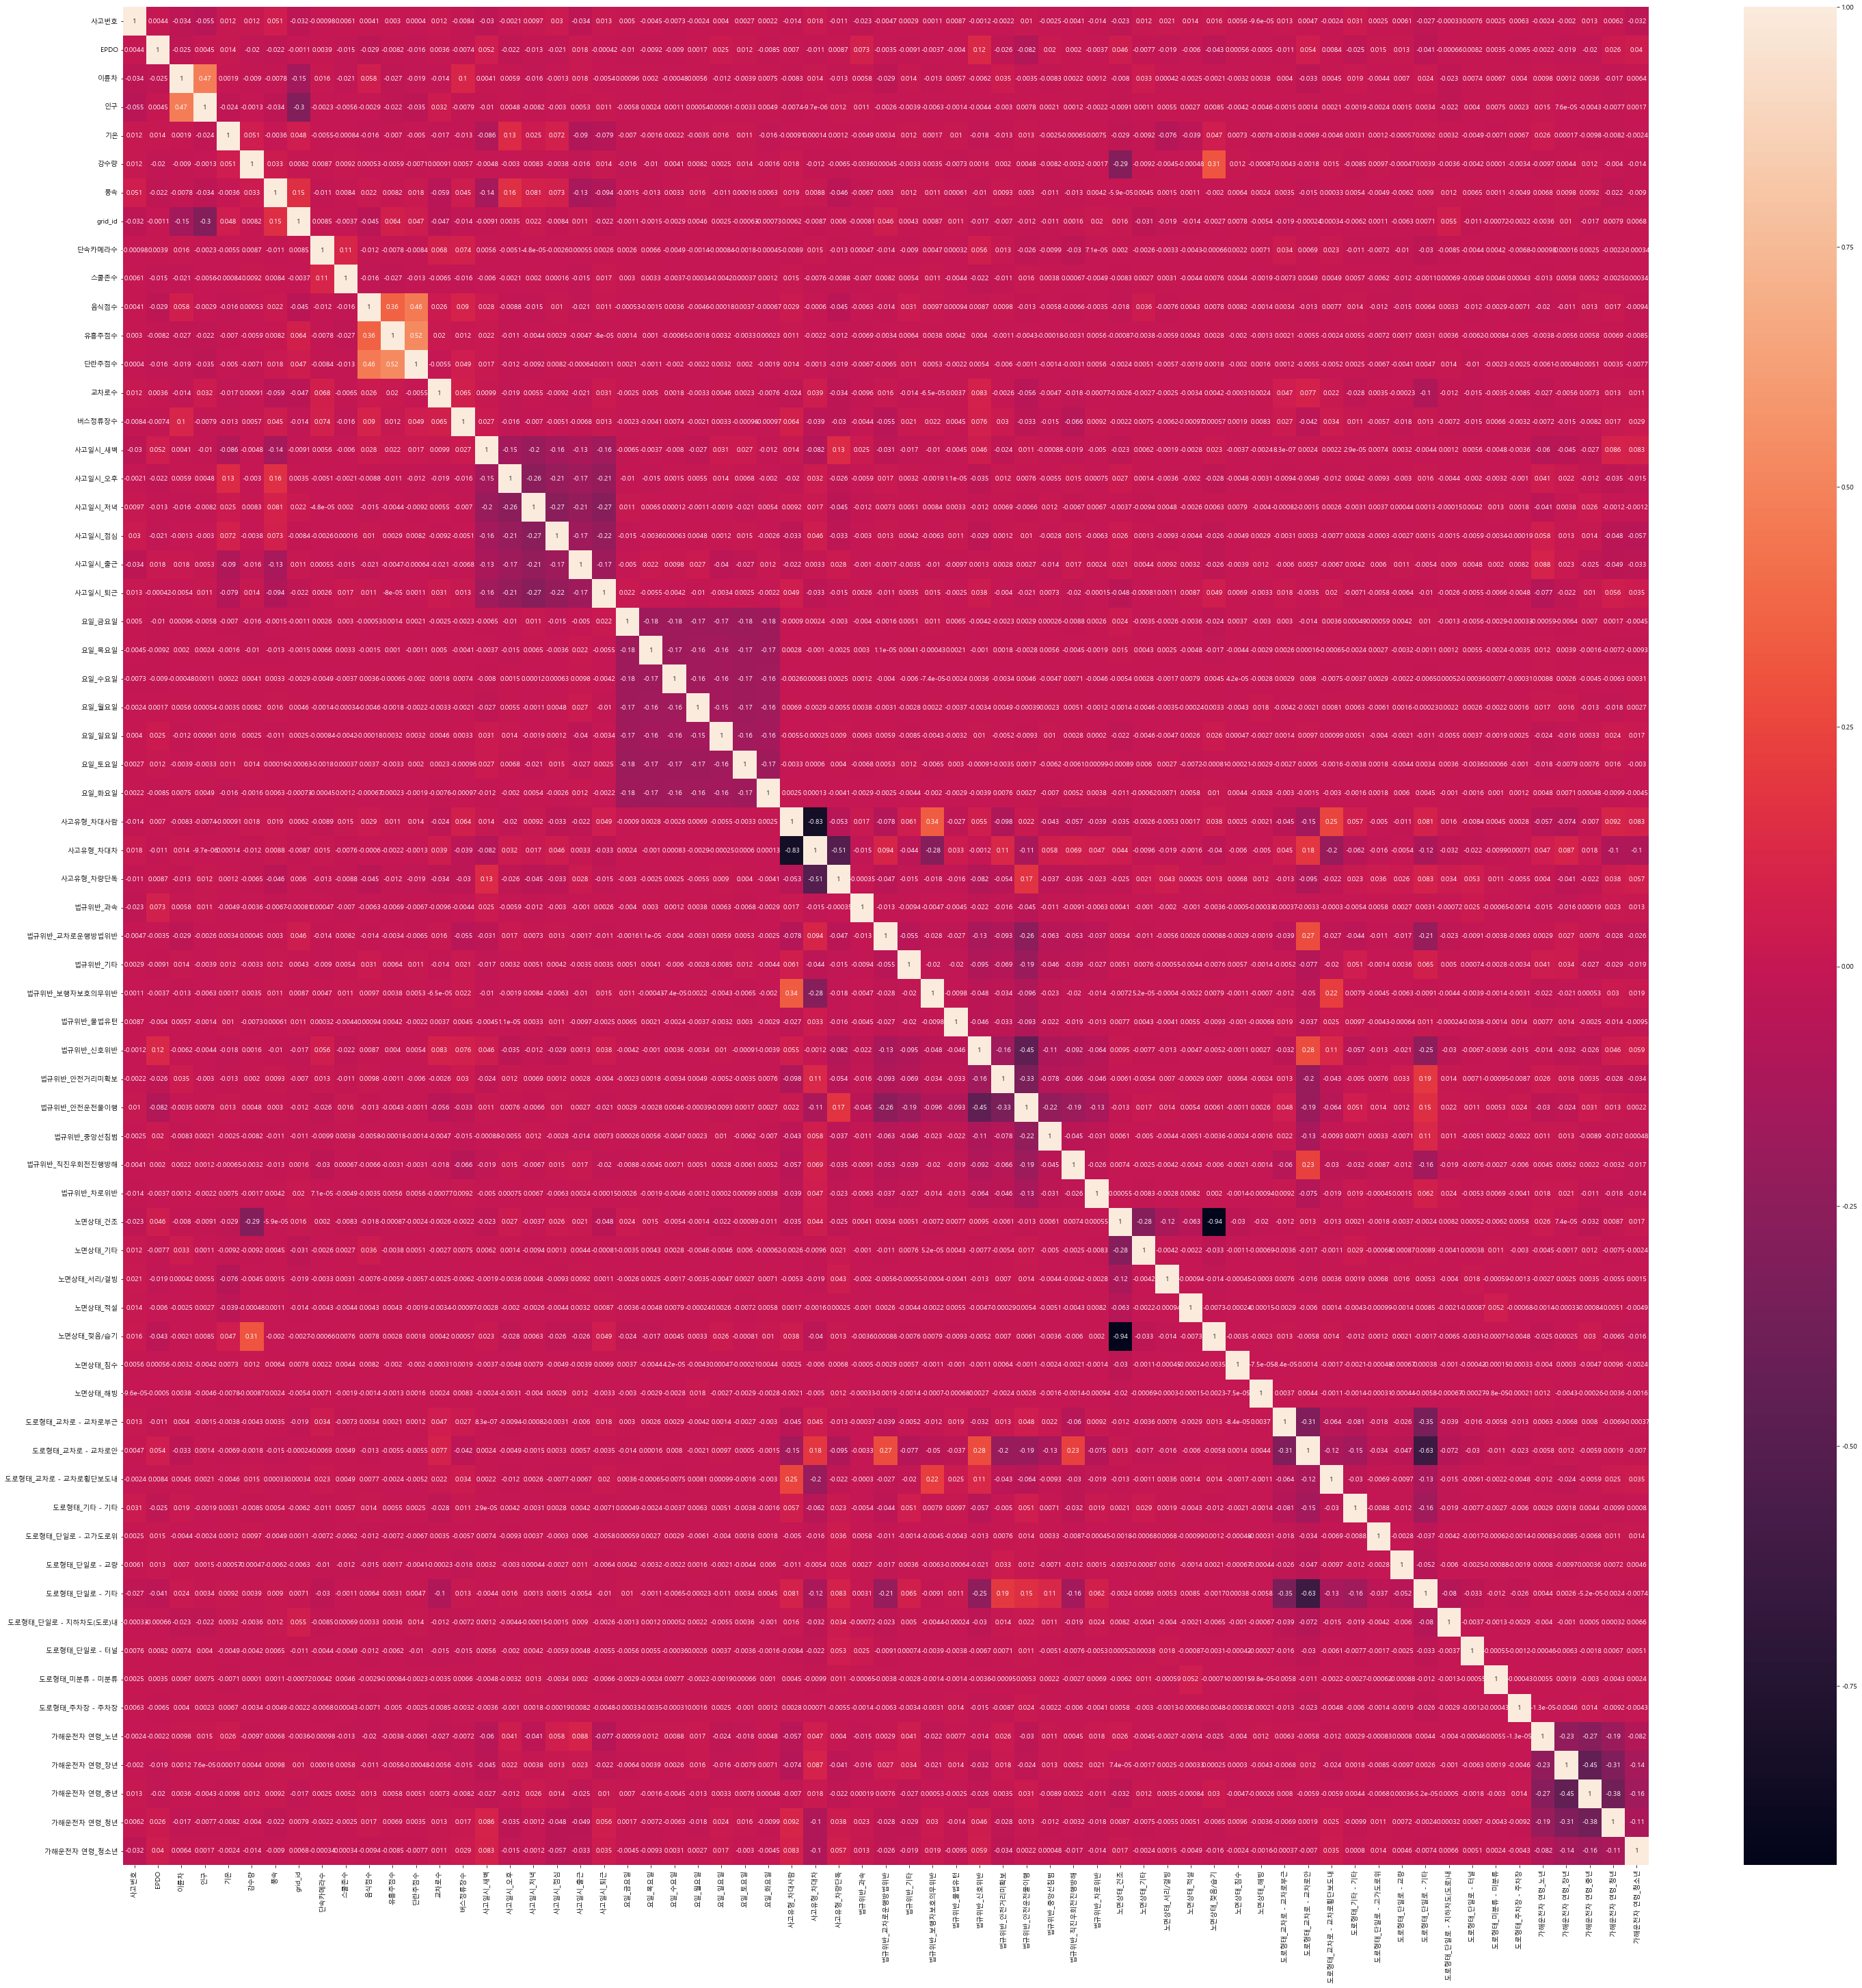

In [16]:
plt.figure(figsize=(50,50))
sns.heatmap(taas_2_dum.corr(), annot=True)
plt.show()

In [17]:
X_taas_2_dum = taas_2_dum.drop(['사고번호','EPDO','가해운전자 차종','grid_id'],axis=1)
y_taas_2_dum = taas_2_dum['EPDO']

In [18]:
vif = pd.DataFrame()
vif["features"] = X_taas_2_dum.columns
vif["VIF Factor"] = [variance_inflation_factor(X_taas_2_dum.values, i) for i in range(X_taas_2_dum.shape[1])]
vif

C:\Users\jwshi\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,features,VIF Factor
0,이륜차,1.329608
1,인구,1.306222
2,기온,1.058408
3,강수량,1.107659
4,풍속,1.092806
5,단속카메라수,1.027772
6,스쿨존수,1.015845
7,음식점수,1.330713
8,유흥주점수,1.417641
9,단란주점수,1.568815


In [19]:
X_taas_2_dum_new = taas_2_dum.drop(['EPDO'],axis=1)

In [20]:
X_taas_2_dum_new.describe()

,사고번호,이륜차,인구,기온,강수량,풍속,grid_id,단속카메라수,스쿨존수,음식점수,유흥주점수,단란주점수,교차로수,버스정류장수,사고일시_새벽,사고일시_오후,사고일시_저녁,사고일시_점심,사고일시_출근,사고일시_퇴근,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일,사고유형_차대사람,사고유형_차대차,사고유형_차량단독,법규위반_과속,법규위반_교차로운행방법위반,법규위반_기타,법규위반_보행자보호의무위반,법규위반_불법유턴,법규위반_신호위반,법규위반_안전거리미확보,법규위반_안전운전불이행,법규위반_중앙선침범,법규위반_직진우회전진행방해,법규위반_차로위반,노면상태_건조,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,노면상태_침수,노면상태_해빙,도로형태_교차로 - 교차로부근,도로형태_교차로 - 교차로안,도로형태_교차로 - 교차로횡단보도내,도로형태_기타 - 기타,도로형태_단일로 - 고가도로위,도로형태_단일로 - 교량,도로형태_단일로 - 기타,도로형태_단일로 - 지하차도(도로)내,도로형태_단일로 - 터널,도로형태_미분류 - 미분류,도로형태_주차장 - 주차장,가해운전자 연령_노년,가해운전자 연령_장년,가해운전자 연령_중년,가해운전자 연령_청년,가해운전자 연령_청소년
count,6.140400e+04,61404.000000,6.140400e+04,61404.000000,61404.000000,61404.000000,6.140400e+04,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.00000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.00000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000,61404.000000
mean,2.020073e+15,15268.165934,3.865202e+05,15.695010,0.157359,2.439654,2.645117e+06,0.190753,0.114976,16.060534,0.609488,0.378461,1.184353,1.653703,0.105009,0.167790,0.251140,0.174712,0.120025,0.181324,0.159094,0.142743,0.141489,0.137108,0.12807,0.149811,0.141685,0.079278,0.889323,0.031399,0.002166,0.069816,0.038890,0.010032,0.009315,0.183034,0.104065,0.478568,0.049720,0.036659,0.017735,0.889453,0.00969,0.001791,0.000489,0.098414,0.000114,0.000049,0.145626,0.365009,0.023516,0.037050,0.001987,0.003909,0.411260,0.008973,0.001531,0.000195,0.000945,0.120823,0.273370,0.351394,0.207364,0.047049
std,8.163621e+11,6207.002422,2.148673e+05,9.720364,1.265073,1.431864,8.319865e+05,0.470810,0.412306,24.834551,3.196813,1.269430,1.411869,1.976007,0.306568,0.373683,0.433672,0.379723,0.324993,0.385289,0.365767,0.349814,0.348528,0.343964,0.33417,0.356889,0.348729,0.270175,0.313734,0.174394,0.046490,0.254839,0.193334,0.099657,0.096066,0.386697,0.305347,0.499545,0.217367,0.187924,0.131988,0.313572,0.09796,0.042288,0.022098,0.297876,0.010677,0.006990,0.352733,0.481437,0.151538,0.188885,0.044530,0.062397,0.492066,0.094303,0.039096,0.013978,0.030719,0.325924,0.445693,0.477410,0.405422,0.211746
min,2.019010e+15,696.000000,2.033100e+04,-18.500000,0.000000,0.000000,2.081900e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.019101e+15,10290.000000,2.542390e+05,8.100000,0.000000,1.400000,2.032466e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.020071e+15,14886.000000,3.718900e+05,16.800000,0.000000,2.300000,2.164327e+06,0.000000,0.000000,7.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00

### Scaling

In [21]:
taas_2_dum.to_csv('data/taas/taas_modeling.csv', index=False, encoding='cp949')